# MLOps for Adult Lung Segmentation 

## Imports

In [9]:
import torch
from torch.utils.data import random_split
from torch import optim
import pytorch_lightning as pl
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import monai
from monai.losses import DiceCELoss
from monai.networks.nets import UNETR
from monai.data import DataLoader, Dataset
from monai.transforms import ( Compose, Resized, 
                              ToTensord, NormalizeIntensityd, 
                              LoadImaged, EnsureChannelFirstd, 
                              RandAffined )
import numpy as np
import glob
import SimpleITK as sitk

print(torch.cuda.is_available())

True


## Data Loader - using a Custom Dataset and Pytorch Lightning

In [10]:
ROOT_DIR = "C:/Users/sadhana.ravikumar/Documents/LungAirProject/LungAir_MLOps"

DATA_DIR = os.path.join(ROOT_DIR,"MontgomerySet","MontgomerySet") # CXR_png, ManualMask/leftMask, rightMask

image_path = os.path.join(DATA_DIR,'CXR_png')
leftmask_path = os.path.join(DATA_DIR,'ManualMask','leftMask')
rightmask_path = os.path.join(DATA_DIR,'ManualMask','rightMask')

list = os.listdir(image_path)
idx = 3

left_name = os.path.join(leftmask_path,list[idx])
right_name = os.path.join(rightmask_path,list[idx])

left = sitk.GetArrayFromImage(sitk.ReadImage(left_name))/255
right = sitk.GetArrayFromImage(sitk.ReadImage(right_name))/255

seg = left+right

print(np.unique(seg))
print(left.shape)
print(np.unique(right))

[0. 1.]
(4892, 4020)
[0. 1.]


In [11]:
class ApplyTransform(Dataset):
    """
    Apply transformations to a Dataset

    Arguments:
        dataset (Dataset): A Dataset that returns (sample, target)
        transform (callable, optional): A function/transform to be applied on the sample

    """
    def __init__(self, dataset, transform=None):

        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, idx):
        sample = self.dataset[idx]

        if self.transform is not None:
            sample = self.transform(sample)

        return sample

    def __len__(self):
        return len(self.dataset)
    
class LungSegmentationDataset(Dataset):
    def __init__(self, image_path,
                 leftmask_path,
                 rightmask_path, transforms):
        
        self.image_path = image_path
        self.leftmask_path = leftmask_path
        self.rightmask_path = rightmask_path
        self.list =  os.listdir(self.image_path)
        self.transform = transforms

    def __len__(self):
        return len(self.list)
    
    def __getitem__(self, idx):

        # Load Image and corresponding segmentation masks
        img_name = os.path.join(self.image_path,self.list[idx])
        left_name = os.path.join(self.leftmask_path,self.list[idx])
        right_name = os.path.join(self.rightmask_path,self.list[idx])

        img = sitk.GetArrayFromImage(sitk.ReadImage(img_name))
        left = sitk.GetArrayFromImage(sitk.ReadImage(left_name))
        right = sitk.GetArrayFromImage(sitk.ReadImage(right_name))

        seg = left + right #  Combine the right and left masks

        sample = {'image':img,'label':seg,'filename': self.list[idx]}

        if self.transform is not None:
            sample = self.transform(sample)
        
        return sample

In [16]:
class LungSegmentationDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size, num_workers):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.image_path = os.path.join(self.data_dir,'CXR_png')
        self.leftmask_path = os.path.join(self.data_dir,'ManualMask','leftMask')
        self.rightmask_path = os.path.join(self.data_dir,'ManualMask','rightMask')
        self.num_workers = num_workers

        self.dims = 2

        self.transforms = Compose([EnsureChannelFirstd(keys=["image","label"], channel_dim='no_channel'), 
            Resized(keys=['image','label'], spatial_size = (512,512), mode=("bilinear","nearest")),
            NormalizeIntensityd(keys=['image','label']),
            ToTensord(keys=["image","label"])])
        
        self.aug_transforms = RandAffined(keys=['image','label'],mode=('bilinear','nearest'),prob=0.1,rotate_range=(0, 0, np.pi))

    def prepare_data(self):
        """
        Empty prepare_data method left in intentionally. 
        https://pytorch-lightning.readthedocs.io/en/latest/data/datamodule.html#prepare-data
        This function is used if downloading data . Processes that occcur on a single processing unit
        """
        pass

    def setup(self, stage):

        # Assign train/val datasets for use in datlaloaders
        entire_dataset =  LungSegmentationDataset(
            self.image_path,
            self.leftmask_path,
            self.rightmask_path,
            transforms = self.transforms)
        
        # Split data
        generator = torch.Generator().manual_seed(42) # reproducible split
        self.train_ds, self.val_ds, self.test_ds = random_split(entire_dataset,[0.7,0.2,0.1], generator=generator)

        # Apply data augmentation transfprms to train_ds
        self.train_ds = ApplyTransform(self.train_ds, self.aug_transforms)

    def train_dataloader(self):
        return DataLoader(self.train_ds,
            batch_size = self.batch_size,
            num_workers = self.num_workers,
            shuffle=True)
        
    def val_dataloader(self):
        return DataLoader(self.val_ds,
            batch_size = self.batch_size,
            num_workers = self.num_workers,
            shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.test_ds,
            batch_size = self.batch_size,
            num_workers = self.num_workers,
            shuffle=False)

### Test out dataset and plot image

Image shape torch.Size([1, 512, 512])


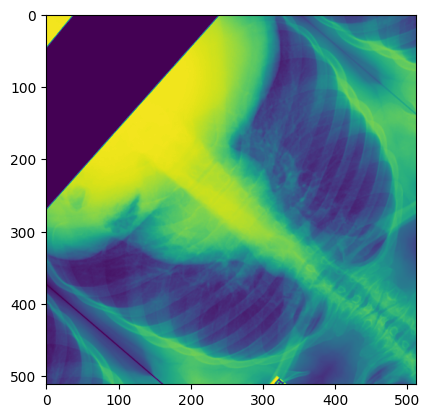

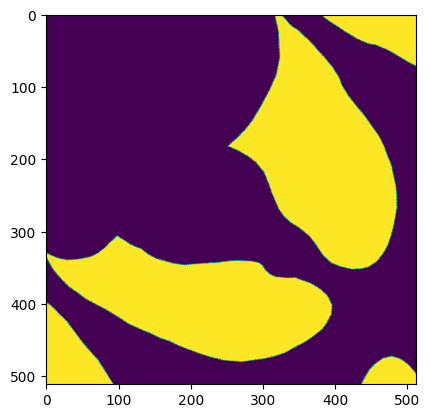

In [17]:
transforms = Compose([EnsureChannelFirstd(keys=['image','label'], channel_dim='no_channel'),
            Resized(keys=['image','label'], spatial_size = (512,512)),
            NormalizeIntensityd(keys=['image','label']),
            ToTensord(keys=['image','label'])])
        
# Resized(keys=['image','label'], spatial_size = (512,512), mode = ('bilinear', 'nearest')), 
aug_transforms = RandAffined(keys=['image','label'],mode=('bilinear','nearest'),prob=1,rotate_range=(np.pi, 0, np.pi))

ds = LungSegmentationDataset(image_path,leftmask_path,rightmask_path,transforms=transforms)
aug_ds = ApplyTransform(ds, aug_transforms)

sample = aug_ds[4]

import matplotlib.pyplot as plt
img = sample["image"]
seg = sample["label"]
print("Image shape",img.shape)
plt.imshow(img[0])
plt.figure()
plt.imshow(seg[0])


## Network Module

In [18]:
class Net(pl.LightningModule):
    def __init__(self, input_size, num_classes):
        super().__init__()

        self.model = UNETR(in_channels = 1, out_channels = num_classes, img_size = input_size, spatial_dims=2)
        self.loss = DiceCELoss(to_onehot_y=True, softmax=True)

    def forward(self,x):
        x = self.model(x)
        return x

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.001)

    def training_step(self, batch, batch_idx):
        loss, pred, y = self.common_step(batch,batch_idx)
        return loss, pred, y
        # can return loss, log values

    def validation_step(self, batch, batch_idx):
        # validation loigic
        loss, pred, y = self.common_step(batch,batch_idx)
        return loss, pred, y

    def common_step(self, batch, batch_idx):
        # training logic
        x = batch["image"]
        y = batch["label"]

        pred = self.forward(x)
        loss = self.loss(pred,y)

        return loss, pred, y

In [15]:
# Hyperparameters

input_size = (512,512)
num_classes = 2
learning_rate = 0.001
batch_size = 4
num_epochs = 2

In [19]:
dm = LungSegmentationDataModule(DATA_DIR,batch_size=4, num_workers=0)
print(torch.cuda.is_available())
model = Net(input_size=input_size, num_classes=num_classes)


trainer = pl.Trainer(accelerator = "gpu")

trainer.fit(model,dm)
# trainer.validate(model,dm)
# trainer.test(model,dm)

True


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A2000 8GB Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
